# L6b: Implementation of the Weighted Majority Algorithm for Online Learning
In this lab, we will implement and play with the Weighted Majority Algorithm online learning algorithm for a daily growth rate guessing game. Before we start, please review the Weighted Majority Algorithm.

## Weighted Majority Algorithm
Let's start with the Weighted Majority Algorithm developed by [Littlestone and Warmuth in 1994](https://www.sciencedirect.com/science/article/pii/S0890540184710091). We illustrate this approach with an example found in [Arora et al., 2005, Princeton](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-6/L6a/docs/Arora-MWsurvey-CS-Princeton.pdf), which is a _prediction from expert advice_ problem. Let's take a look at the framing: 

* __Game__: The game's objective is to predict the daily stock price movement as either `up` or `down,` (which we encode as `{1 | -1}`). Each morning, we forecast the daily price direction, and by market close, we learn the actual movement. If we predict _incorrectly_, we lose a dollar. We aim to minimize losses. Our predictions are informed by the forecasts of $n$ experts, whose predictions may be correlated and accurate or not.
* __Goal__: The weighted majority algorithm limits losses to about the best expert without knowing who that is until the end of the sequence. Each day, it requires decisions. The algorithm maintains a weighting of experts, initially giving them equal weight. Over time, those making better predictions have increased weight proportionately.

We play this game between an omniscient _adversary_ (nature, i.e., the market) and an _aggregator_ (us) who $n$ experts advise; we select $n$ as odd to avoid ties. The game proceeds in rounds $t = 1, 2, \ldots, T$. During each round the aggregator (us) makes a _binary_ decision $y_t \in \{-1, 1\}$, and the adversary (market) reveals the true outcome $y_t$. Initially, the experts have weights $\left\{w_{i}^{(1)} = 1 \mid i = 1, 2, \ldots, n\right\}$. 

### Algorithm
For each round $t=1,2,\dots,T$:
1. The aggregator (us) makes a prediction $y_t \in \{-1, 1\}$ based on the weighted majority of the experts' predictions. If the total weight of all experts predicting `1` at time $t$ is $w^{(t)}\geq\sum_{i}w_{i}^{(t)}/2$, then the aggregator predicts `1`, otherwise it predicts `-1`.
2. The adversary (market) reveals the actual outcome $y_t \in \{-1, 1\}$.
3. We decrease the weights of the experts who predicted incorrectly. For each expert $i$ who predicted incorrectly, we update the weight: $w_{i}^{(t+1)} = w_{i}^{(t)}(1-\epsilon)$, where $0<\epsilon\leq{1/2}$ is a learning rate parameter.

__Theorem__: The weighted majority algorithm has the following theoretical guarantee (which bounds the number of mistakes the aggregator makes). Let $m_{i}^{(t)}$ be the number of mistakes made by expert $i$ up to time $t$ and $m^{(t)}$ be the total number of mistakes made by the aggregator (us). Then, for every expert $i$ and the aggregator, we have:
$$
\begin{align*}
m^{(t)} \leq \frac{2\ln(n)}{\epsilon} + 2\left(1+\epsilon\right)m_{i}^{(t)}
\end{align*}
$$

### Tasks
Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Constants (5 min)__: Let's take 5 minutes to explore the daily growth rate dataset for the components of the [SP500](https://en.wikipedia.org/wiki/S%26P_500).
* __Task 2: Implement the Weighted Majority Algorithm (25 min)__: In this task, we'll implement a data-driven expert strategy in which we use (potentially) time-delayed growth rate data from other tickers to predict whether or not the [SPY 500 ETF `SPY`](https://en.wikipedia.org/wiki/SPDR_S%26P_500_ETF_Trust) will go up or down during a trading day.
* __Task 3: Test the theoretical mistake bound (10 min)__: In this task, we'll test the theorem governing the upper bound on the number of mistakes an aggregator (us) will make relative to the system's experts.

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

### Data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `02-07-2025`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 515 entries:
  "TPR"  => 1828×8 DataFrame…
  "EMR"  => 2792×8 DataFrame…
  "CTAS" => 2792×8 DataFrame…
  "HSIC" => 2792×8 DataFrame…
  "KIM"  => 2792×8 DataFrame…
  "PLD"  => 2792×8 DataFrame…
  "IEX"  => 2792×8 DataFrame…
  "KSU"  => 2001×8 DataFrame…
  "BAC"  => 2792×8 DataFrame…
  "CBOE" => 2792×8 DataFrame…
  "EXR"  => 2792×8 DataFrame…
  "NCLH" => 2792×8 DataFrame…
  "CVS"  => 2792×8 DataFrame…
  "DRI"  => 2792×8 DataFrame…
  "DTE"  => 2792×8 DataFrame…
  "ZION" => 2792×8 DataFrame…
  "AVY"  => 2792×8 DataFrame…
  "EW"   => 2792×8 DataFrame…
  "EA"   => 2792×8 DataFrame…
  "NWSA" => 2792×8 DataFrame…
  "BBWI" => 884×8 DataFrame…
  "CAG"  => 2792×8 DataFrame…
  "GPC"  => 2792×8 DataFrame…
  "FCX"  => 2792×8 DataFrame…
  "GILD" => 2792×8 DataFrame…
  ⋮      => ⋮

__Clean the data__: Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

2792

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = let

    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end;

Let's get a list of firms in the cleaned up `dataset` and save it in the `all_tickers` array. We sort the firms alphabetically from `A` to `Z`:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

Compute the expected (annualized) excess log growth rate by passing the `dataset` and the entire list of firms we have in the dataset to the [log_growth_matrix(...) method](src/Compute.jl). The log growth rate between time period $j-1$ to $j$, e.g., yesterday to today is defined as:
$$
\begin{equation}
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\ln\left(\frac{S_{j}}{S_{j-1}}\right)
\end{equation}
$$
where $\Delta{t}$ denotes the period time step, and $S_{j}$ denote share price in period $j$.
* The log growth rates are stored in the `D::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of the `D` matrix corresponds to a time value, while each column corresponds to a firm.

In [13]:
D = let

    # setup some constants -
    Δt = (1/252); # 1-trading day in units of years
    risk_free_rate = 0.0415; # inferred cc risk-free rate

    # compute
    μ = log_growth_matrix(dataset, list_of_all_tickers, Δt = Δt, 
        risk_free_rate = risk_free_rate);

    μ # return to the caller
end;

Next, let's [z-score center](https://en.wikipedia.org/wiki/Feature_scaling) the continous feature data. 
* In [z-score feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), we subtract off the mean of each feature and then divide by the standard deviation, i.e., $x^{\prime} = (x - \mu)/\sigma$ where $x$ is the unscaled data, and $x^{\prime}$ is the scaled data. Under this scaling regime, $x^{\prime}\leq{0}$ will be values that are less than or equal to the mean value $\mu$, while $x^{\prime}>0$ indicate values that are greater than the mean.

We save the z-score centered growth data in the `D̄::Array{Float64,2}` variable:

In [15]:
D̄ = let

    # setup -
    number_of_examples = size(D,1);

    D̄ = copy(D);
    for j ∈ eachindex(list_of_all_tickers)
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̄[k,j] = (D[k,j] - μ)/σ;
        end
    end
    
    D̄
end

2791×424 Matrix{Float64}:
 -0.270236    0.875241   -0.51285    …  -0.172603    0.0340086  -0.326599
  0.735235    0.153683    0.270667       0.365351   -0.156963    0.235764
  0.870466    0.123779    0.0157621     -0.0117454   0.206118   -0.771629
  0.144598    2.39589     0.325758       0.018899    0.564557   -0.146732
  0.462985    0.362567    0.624783       0.0834006  -0.405704    1.20044
  0.135725   -0.543745   -0.130921   …  -0.192559   -0.35855    -0.922629
  0.747335   -0.0617295   0.905321       0.29608    -0.334345   -0.35041
  0.52576     0.145651    0.365443       0.279399    0.799572   -0.0816769
  0.326013    0.237151    0.0344876     -0.312346   -0.399924    0.363208
  0.30077     0.854261    0.186164      -0.316981    0.513302   -0.448288
 -0.150497    0.679814    0.199977   …  -0.0918959   1.72074    -0.892273
  0.339601    0.505721   -0.416694       0.0999343   0.812754    0.0533844
 -1.32135     0.197223   -0.539546      -0.432322   -1.22161     0.354251
  ⋮         

Next, let's set up a ticker map that holds the index of each ticker value. We'll save this in the `tickerindexmap::Dict{String,Int}` dictionary:

In [17]:
tickerindexmap = let

    # initialize -
    tickerindexmap = Dict{String,Int}();
    for i ∈ eachindex(list_of_all_tickers)
        tickerindexmap[list_of_all_tickers[i]] = i;
    end

    tickerindexmap;
end

Dict{String, Int64} with 424 entries:
  "EMR"  => 132
  "CTAS" => 101
  "HSIC" => 187
  "KIM"  => 217
  "PLD"  => 310
  "IEX"  => 194
  "BAC"  => 48
  "CBOE" => 69
  "EXR"  => 144
  "NCLH" => 271
  "CVS"  => 103
  "DRI"  => 119
  "DTE"  => 120
  "ZION" => 423
  "AVY"  => 43
  "EW"   => 140
  "EA"   => 124
  "NWSA" => 289
  "CAG"  => 65
  "GILD" => 161
  "FCX"  => 148
  "GPC"  => 168
  "UNP"  => 390
  "CDW"  => 73
  "SBUX" => 339
  ⋮      => ⋮

## Task 2: Implement the Weighted Majority Algorithm
In this task, we'll implement a data-driven expert strategy in which we use (potentially) time-delayed growth rate data from other tickers to predict whether or not the [SPY 500 ETF `SPY`](https://en.wikipedia.org/wiki/SPDR_S%26P_500_ETF_Trust) will go up or down during a trading day.

First, we'll define the `expert` and `adversary` functions.

* The `expert(index::Int, time::Int, data::Array{Float64,2})::Int` function takes the `index::Int` of the expert, the current time step `t::Int` and the market `data::Array{Float64,2})` array which is the _actual_ growth rate data `D̄`. This function returns the _prediction_ from expert $i$, namely $y_{t}^{(i)}$.

In [20]:
function expert(index::Int, time::Int, data::Array{Float64,2})::Int

    # These are my choices for experts: you pick yours
    # expert 1: QQQ
    # expert 2: NVDA
    # expert 3: AMD
    # expert 4: AAPL
    # expert 5: MSFT
    
    i = nothing;
    if (index == 1)
        i = tickerindexmap["QQQ"];
    elseif (index == 2)
        i = tickerindexmap["NVDA"];
    elseif (index == 3)
        i = tickerindexmap[""];
    elseif (index == 4)
        i = tickerindexmap["JNJ"];
    elseif (index == 5)
        i = tickerindexmap["AAPL"];
    end
    return data[time+1,i] |> sign;
end;

* The `adversary(time::Int, data::Array{Float64,2})::Int` function takes the current time step `t::Int` and the market `data::Array{Float64,2})` array and returns the true answer $y_{t}$ for the `SPY` growth rate for time $t$:

In [22]:
function adversary(time::Int, data::Array{Float64,2})::Int

    # adversary is SPY -
    result = tickerindexmap["SPY"] |> i-> data[time,i] |> sign;
    return result
end;

Next, we'll build [a `model::MyBinaryWeightedMajorityAlgorithmModel` instance](src/Types.jl) that holds all the data associated with the problem [using a `build(...)` method](src/Factory.jl). 

In [24]:
model = let

    # build -
    model = build(MyBinaryWeightedMajorityAlgorithmModel, (
        ϵ = 0.49, # learning rate 
        n = 5, # number of experts (needs to be odd to avoid ties)
        T = 252, # number of rounds
        expert = expert, # expert function
        adversary = adversary, # adversary function
    ));

    # return the model -
    model;
end;

Finally, we call [the `play(...)` method](src/Online.jl) to run the simulation. The [`play(...)` method](src/Online.jl) takes the `model::MyBinaryWeightedMajorityAlgorithmModel` instance and the data matrix `D̄::Array{Float64,2}` and returns two arrays:
* The `sims::Array{Float64,2}` holds simulation information. Each row corresponds to a time `t.` The first $n$ columns correspond to the predictions of experts $i=1,2,\dots,n$ at a time `t.` Column $n+1$ corresponds to the aggregator (us) prediction, and column $n+2$ corresponds to the adversary prediction at time `t.` Finally, the last column holds the loss value $l_{t}$ for the aggregator.
* The `weights::Array{Float64,2}` array holds the weights for each expert in our system. The rows of this array correspond to the timesteps `t`, while each column holds the $w_{i}^{(t)}$ values.

In [26]:
(sims, weights) = play(model, D̄);

In [27]:
sims

252×8 Matrix{Int64}:
  1  -1   1   1  -1   1  -1  1
 -1  -1  -1  -1   1  -1   1  1
  1   1  -1   1  -1  -1   1  1
 -1  -1   1  -1  -1  -1  -1  0
 -1  -1   1  -1   1  -1   1  1
  1  -1   1   1   1   1  -1  1
 -1   1  -1   1   1   1   1  0
 -1  -1  -1  -1  -1  -1   1  1
 -1  -1  -1   1  -1  -1  -1  0
 -1  -1  -1  -1   1  -1  -1  0
 -1  -1  -1   1   1  -1  -1  0
 -1  -1  -1  -1  -1  -1   1  1
 -1  -1   1  -1  -1  -1  -1  0
  ⋮                   ⋮      
  1   1   1   1   1   1   1  0
  1  -1   1   1   1   1   1  0
  1   1  -1   1   1   1   1  0
  1   1  -1  -1  -1  -1   1  1
 -1   1   1   1  -1  -1   1  1
  1   1   1   1   1   1   1  0
 -1   1  -1   1   1   1   1  0
  1   1  -1   1  -1  -1   1  1
 -1   1  -1  -1  -1  -1  -1  0
 -1  -1   1  -1  -1  -1  -1  0
 -1  -1   1  -1  -1  -1  -1  0
  1  -1   1  -1  -1  -1  -1  0

In [28]:
findall(x-> x == 0, sims[:,end]) |> i-> length(i)/252

0.5753968253968254

`Unhide` the code block below to see how we plotted the weights versus $t$ for the experts in our system. 

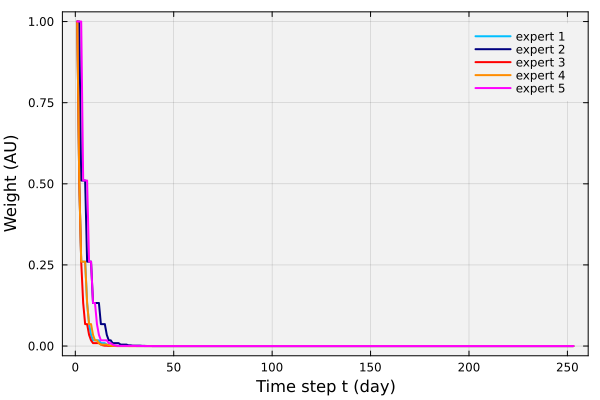

In [30]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); 
    plot!(weights[:,1], c=:deepskyblue1, lw=2, label="expert 1")
    plot!(weights[:,2],c=:navy, lw=2, label="expert 2")
    plot!(weights[:,3],c=:red, lw=2, label="expert 3")
    plot!(weights[:,4],c=:darkorange, lw=2, label="expert 4")
    plot!(weights[:,5],c=:magenta, lw=2, label="expert 5")
    xlabel!("Time step t (day)", fontsize=18)
    ylabel!("Weight (AU)", fontsize=18)
end

## Task 3: Test the theoretical mistake bound
In this task, we'll test the theorem governing the upper bound on the number of mistakes an aggregator (us) will make relative to the system's experts.

__Theorem__: The weighted majority algorithm has the following theoretical guarantee (which bounds the number of mistakes the aggregator makes). Let $m_{i}^{(t)}$ be the number of errors made by expert $i$ up to time $t$ and $m^{(t)}$ be the total number of errors made by the aggregator (us) up to time $t$. Then, for every expert $i$ and the aggregator, we have:
$$
\begin{align*}
m^{(t)} \leq \frac{2\ln(n)}{\epsilon} + 2\left(1+\epsilon\right)m_{i}^{(t)}
\end{align*}
$$

Let's start by identifying the best expert in hindsight.

__Which expert was best__? Let's use the _heuristic_ that the best expert will be the one with the highest weight at the end of the game, i.e., $\hat{i} = \text{arg}\max\left(w_{1}^{(T)},w_{2}^{(T)},\dots,w_{n}^{(T)}\right)$

In [33]:
î = argmax(weights[end,:]) # index of the largest weight at the end

5

Next, we'll compute the number of mistakes by our experts as a function of time $t$. We'll save this in the `m_experts::Array{Int64,2}` array where each row corresponds to a time index $t$, and each column is loss suffered by each expert. 
* In this case, if the expert was _incorrect_ they have a loss of `1`; otherwise, they have a loss of `0`.

In [35]:
m_experts = let

    # data -
    n = model.n; # number of experts
    T = model.T; # number of rounds in the game
    m = Array{Int64,2}(undef, T, n);

    for t ∈ 1:T
        for j ∈ 1:n
            expert_prediction = sims[t,j];
            adversary_prediction = sims[t,end-1]; # adv is the penultimate column
            m[t,j] = expert_prediction == adversary_prediction ? 0 : 1
        end
    end

    # return 
    m
end;

### Compute the bound
Finally, let's compute the bound. We save the left side of the bound (the aggregator term) in the `L::Array{Float64,1}` variable, while the right side is saved in the `R::Array{Float64,1}` variable. 

In [37]:
L,R = let

    # data -
    n = model.n; # number of experts
    T = model.T; # number of rounds in the game
    ϵ = model.ϵ; # Get the learning rate
    L = Array{Float64,1}(undef, T); # left term
    R = Array{Float64,1}(undef, T); # right term
    m_aggregartor = sims[:,end]; # aggregator mistakes on the last column
    m_expert = m_experts[:,î]; # best expert

    # compute the left term L
    for t ∈ 1:T
        L[t] = sum(m_aggregartor[1:t]);
    end
    
    # compute the right term R
    for t ∈ 1:T
        R[t] = (2*log(n)/ϵ) + 2*(1+ϵ)*sum(m_expert[1:t])
    end
    
    L,R
end;

`Unhide` the code block below to see how we plotted the `L` and `R` components of the theoretical bound expression.

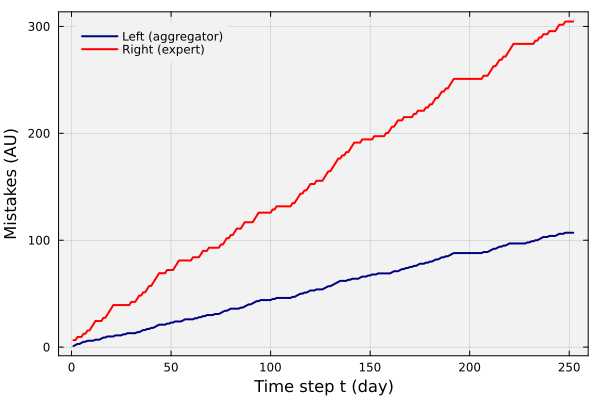

In [39]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot!(L, c=:navy, lw=2, label="Left (aggregator)")
    plot!(R, c=:red, lw=2, label="Right (expert)")
    xlabel!("Time step t (day)", fontsize=18)
    ylabel!("Mistakes (AU)", fontsize=18)
end